####  🍁Check Versions

In [1]:
# !python --version

import cupy as cp
cp.__version__

# !pip show jedi
# !pip show setuptools
# !pip show pip

'13.3.0'

#### 🍁 Set folder

In [2]:
import os

models_dir = "/kaggle/working/models/"  # Kaggle's default working directory

# Ensure the directory exists
os.makedirs(models_dir, exist_ok=True)

### Step 1: Import Data

In [4]:
from sklearn.datasets import fetch_openml
import numpy as np

# Import MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
x_full = mnist.data.values  # Full dataset
y_full = mnist.target.values.astype(int)  # Labels (0–9)

print(f"x_full shape: {x_full.shape}, y_full shape: {y_full.shape}")

/opt/conda/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


x_full shape: (70000, 784), y_full shape: (70000,)


### Step 2: Create Subset

In [5]:
# Create a subset of training data (1000 images per digit)
subset_size = 100
x_subset = []
y_subset = []

for digit in range(10):
    digit_indices = np.where(y_full == digit)[0][:subset_size]
    x_subset.append(x_full[digit_indices])
    y_subset.append(y_full[digit_indices])

x_subset = np.vstack(x_subset)
y_subset = np.hstack(y_subset)

print(f"x_subset shape: {x_subset.shape}, y_subset shape: {y_subset.shape}")
print(f"Unique labels in y_subset: {np.unique(y_subset)}")
print(f"x_subset[3].shape: {x_subset[3].shape}")

x_subset shape: (1000, 784), y_subset shape: (1000,)
Unique labels in y_subset: [0 1 2 3 4 5 6 7 8 9]
x_subset[3].shape: (784,)


### Step 3: Apply PCA

In [15]:
from sklearn.decomposition import PCA
import pickle

# Apply PCA to reduce dimensionality
n_components = 20
pca = PCA(n_components=n_components)
x_pca = pca.fit_transform(x_subset)

# Load PCA instance
with open("models/pca_model.pkl", "wb") as file:
    pickle.dump(pca, file)  # Save the fitted PCA model

print(f"Original shape: {x_subset.shape}, PCA shape: {x_pca.shape}")
print(f"variance retained: {np.sum(pca.explained_variance_ratio_)*100}%")

print(f"shape of x_pca: ", x_pca.shape)
print(f"shape of x_pca[5]: ", x_pca[5].shape)

print(f"check any image vector: ", x_pca[5])

Original shape: (1000, 784), PCA shape: (1000, 20)
variance retained: 66.00934331776499%
shape of x_pca:  (1000, 20)
shape of x_pca[5]:  (20,)
check any image vector:  [1073.16458501 -209.31731563  791.9349834   225.96305438  821.33836512
 -624.52374331 -833.45224807 -471.0246632   -63.53703852  -53.73103906
   94.3053625  -112.0961743   380.31245692 -425.9955943  -252.19020375
  421.54830479  189.39211706  -73.01711337  205.48640401  330.71885856]


### Step 4: Thresholding

In [17]:
# Thresholding: Convert to binary
threshold_value = 0
x_b = (x_pca > threshold_value).astype(int)

print(f"x_b shape: {x_b.shape}")
print(f"x_b[5] =", x_b[5])

print(f"x_b =", x_b)

x_b shape: (1000, 20)
x_b[5] = [1 0 1 1 1 0 0 0 0 0 1 0 1 0 0 1 1 0 1 1]
x_b = [[1 1 0 ... 1 1 1]
 [1 1 0 ... 0 1 0]
 [1 1 0 ... 0 0 0]
 ...
 [1 0 1 ... 1 1 1]
 [0 0 1 ... 1 1 1]
 [0 0 1 ... 1 1 0]]


In [20]:
# Shuffle the dataset
shuffle_indices = np.arange(len(y_subset))
np.random.shuffle(shuffle_indices)

x_b = x_b[shuffle_indices]
y_subset = y_subset[shuffle_indices]

print(f"x_b.shape =", x_b.shape)
print(f"y_subset.shape =", y_subset.shape)

print(f"x_b =", x_b)
print(f"y_subset =", y_subset)

x_b.shape = (1000, 20)
y_subset.shape = (1000,)
x_b = [[1 1 1 ... 0 0 1]
 [0 0 1 ... 0 0 0]
 [1 1 0 ... 0 1 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 0 1 ... 1 0 0]
 [1 0 1 ... 0 0 1]]
y_subset = [5 3 3 2 8 8 8 7 7 9 2 0 4 0 1 3 6 5 5 2 0 4 3 8 0 4 3 9 3 8 1 1 4 9 5 1 7
 4 2 9 1 4 5 3 7 9 5 4 3 0 1 5 1 3 8 7 8 7 6 4 6 6 6 9 6 3 5 3 5 9 1 1 4 2
 3 6 3 0 5 0 9 0 4 3 2 7 7 0 1 3 6 9 8 1 6 4 0 6 5 3 5 3 4 3 7 2 1 3 1 5 2
 7 7 1 4 4 9 9 6 0 4 2 0 0 4 3 0 1 2 3 3 8 0 8 7 7 4 6 3 4 6 7 2 4 5 1 6 3
 3 1 0 1 9 3 2 5 5 1 6 2 6 9 5 9 6 7 5 7 1 6 6 2 7 0 5 0 6 5 8 8 8 4 0 5 5
 7 4 8 3 6 0 9 1 3 9 1 5 4 4 2 9 9 2 2 9 5 1 7 0 0 3 3 1 2 6 1 3 0 5 4 5 9
 9 4 6 4 8 0 8 4 6 5 4 7 2 6 9 9 3 2 7 0 1 9 0 6 1 5 9 0 1 7 4 7 6 5 6 1 9
 2 0 1 4 3 7 6 2 4 7 8 6 1 3 1 8 1 7 5 1 2 8 2 0 0 9 8 2 7 0 8 5 0 2 8 3 6
 0 9 1 4 7 9 8 4 1 7 3 9 1 8 8 8 6 1 1 9 0 8 0 8 0 6 4 1 9 6 8 1 2 6 7 6 8
 5 1 9 5 1 7 5 4 1 5 3 4 0 7 6 0 9 8 1 8 2 8 0 4 1 3 4 2 7 6 0 4 9 6 5 6 5
 2 5 4 7 5 4 0 5 8 3 5 4 2 4 1 2 8 8 2 4 2 0 9 3 9 6 7 4 9 1 2 7 

### Step 5: Train Classifiers

In [21]:
import pickle
import cupy as cp
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt

# Feasibility check function
def check_feasibility_and_compute_coefficients(z, x_b, y_binary):
    num_data_points = x_b.shape[0]
    num_coefficients = n_components + 1  # (+1 for the first constant terms α0 & β0)
    delta = 1e-6  # a small positive value

    # Construct G(x) and H(x) matrices for numerator and denominator
    G = cp.zeros((num_data_points, num_coefficients))  # Numerator matrix
    H = cp.zeros((num_data_points, num_coefficients))  # Denominator matrix

    for i in range(num_data_points):
      G[i, 0] = 1
      H[i, 0] = 1
      for j in range(num_coefficients-1):
        G[i, j+1] = x_b[i, j] ** (j+1)
        H[i, j+1] = x_b[i, j] ** (j+1)

    # print(f"G: {G}")
    # print(f"G.shape =", G.shape)
    # print(f"H: {H}")

    # Construct constraints for Ax <= b
    A = []
    b = []

    for i in range(num_data_points):
        f_plus_z = y_binary[i] + z  # Upper bound
        f_minus_z = y_binary[i] - z  # Lower bound

        # Constraint 1: (f(xi) - z) * β^T H(xi) - α^T G(xi) ≤ θ
        # (-G(xi))αT + (f(xi) - z).H(xi)βT + (-1)θ ≤ 0
        constraint_1 = cp.zeros(2 * num_coefficients + 1)
        # (1) Coefficients of α
        constraint_1[0:num_coefficients] = -G[i]
        # (2) Coefficients of β
        constraint_1[num_coefficients:2 * num_coefficients] = (f_minus_z) * H[i]
        # (3) Coefficient of θ (last element)
        constraint_1[-1] = -1
        A.append(constraint_1)
        b.append(0)

        # Constraint 2: α^T G(xi) + (-1).(f(xi) + z) * β^T H(xi) ≤ θ
        # G(xi).αT + (-1)(f(xi) - z).H(xi)βT + (-1)θ ≤ 0
        constraint_2 = cp.zeros(2 * num_coefficients + 1)
        # (1) Coefficients of α
        constraint_2[0:num_coefficients] = G[i]
        # (2) Coefficients of β
        constraint_2[num_coefficients:2 * num_coefficients] = -(f_plus_z) * H[i]
        # (3) Coefficient of θ (last element)
        constraint_2[-1] = -1
        A.append(constraint_2)
        b.append(0)

        # Constraint 3: β^T H(x) ≥ δ
        # (0)α^T + (-H(x)) β^T + (0)θ ≤ -δ
        constraint_3 = cp.zeros(2 * num_coefficients + 1)
        # Coefficient of β
        constraint_3[num_coefficients:2 * num_coefficients] = -H[i]
        A.append(constraint_3)
        b.append(-delta)

    # Convert CuPy arrays to NumPy arrays for SciPy
    A = cp.asnumpy(cp.array(A))
    b = cp.asnumpy(cp.array(b))

    # print(f"A =", len(A))
    # print(f"A: {A[0]}")
    # print(f"A.shape =", A.shape)
    # print(f"len(A[0]): {len(A[0])}")
    # print(f"len(b): {len(b)}")
    # print(f"n_components =", n_components)

    # Objective function to minimize θ
    c = cp.asnumpy(cp.zeros(2 * num_coefficients + 1))
    c[-1] = 1  # Only θ has a coefficient in the objective function

    # Solve the linear programming problem (methods: highs, revised simplex)
    result = linprog(c, A_ub=A, b_ub=b, method="highs")

    # Check feasibility and return results
    if result.success:
        alpha_coefficients = result.x[:num_coefficients]
        beta_coefficients = result.x[num_coefficients:2 * num_coefficients]
        theta = result.x[-1]
        return True, alpha_coefficients, beta_coefficients, theta
    else:
        return False, None, None, None


# Bisection loop
def bisection_loop(x_b, y_binary, uL, uH, precision):
    optimal_alpha, optimal_beta, optimal_theta = None, None, None
    z_values = []

    while uH - uL > precision:
        z = (uL + uH) / 2
        z_values.append(z)
        feasible, alpha_coefficients, beta_coefficients, theta = check_feasibility_and_compute_coefficients(z, x_b, y_binary)

        if feasible:
            uH = z
            optimal_alpha, optimal_beta, optimal_theta = alpha_coefficients, beta_coefficients, theta
        else:
            uL = z

    return uH, optimal_alpha, optimal_beta, optimal_theta, z_values

# Train a classifier for each digit
for digit in range(10):
    print(f"Training classifier for digit {digit}...")

    y_subset = cp.array(y_subset)

    # Assign labels: Positive for the current digit, negative for others
    y_binary = (y_subset == digit).astype(int)

    print(f"y_binary =", y_binary)
    print(f"y_subset =", y_subset)

    # Bisection parameters
    uL = 0  # Initial lower bound
    uH = 5000  # Initial upper bound
    precision = 1e-6 # Precision threshold

    # Run bisection loop
    optimal_z, optimal_alpha, optimal_beta, optimal_theta, z_values = bisection_loop(x_b, y_binary, uL, uH, precision)

    # Print results
    print(f"Number of Iterations: {len(z_values)}")
    # print(f"z Values in all Iterations: {z_values}")
    print(f"Optimal z (Maximum Deviation): {optimal_z}")

    # # Plot convergence of z values
    # plt.figure(figsize=(8, 6))
    # plt.plot(range(len(z_values)), z_values, marker='o', linestyle='-')
    # plt.xlabel("Iteration")
    # plt.ylabel("z Value")
    # plt.title("Convergence of z Values")
    # plt.grid(True)
    # plt.show()

    print(f"Optimized Coefficients (Numerator α): {optimal_alpha}")
    print(f"Optimized Coefficients (Denominator β): {optimal_beta}")
    print(f"Optimal θ: {optimal_theta}")
    
    # print(f"rational_function =", rational_function(x_b[0], optimal_alpha, optimal_beta))

    # Save the model
    model = {
        "alpha": optimal_alpha,
        "beta": optimal_beta,
        "theta": optimal_theta,
        "n_components": n_components
    }

    with open(f"{models_dir}classifier_{digit}.pkl", "wb") as file:
        pickle.dump(model, file)

    print(f"Model for digit {digit} saved at {models_dir}")

Training classifier for digit 0...
y_binary = [0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0

### Testing

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
x_test shape: (10000, 28, 28), y_test shape: (10000,)
Shape of test subset: (10000, 28, 28)
Shape of flattened test subset: (10000, 784)
Shape of PCA-transformed test subset: (10000, 20)
Binary thresholded test subset: (10000, 20)
Accuracy for digit 0: 90.20%
Accuracy for digit 1: 88.65%
Accuracy for digit 2: 89.68%
Accuracy for digit 3: 89.90%
Accuracy for digit 4: 90.18%
Accuracy for digit 5: 91.08%
Accuracy for digit 6: 90.42%
Accuracy for digit 7: 89.72%
Accuracy for digit 8: 90.26%
Accuracy for digit 9: 10.09%
Overall Accuracy: 82.02%


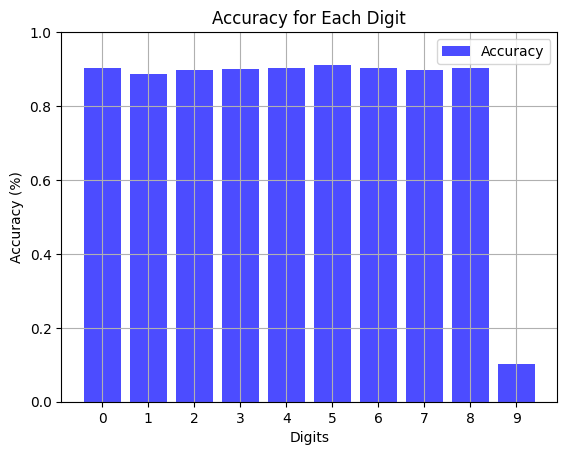

y_pred_binary = [ True  True  True ...  True  True  True]
y_true_binary = [False False False ... False False False]
y_pred_binary.shape = (10000,)
y_true_binary.shape = (10000,)


In [22]:
import cupy as cp
import numpy as np
from sklearn.decomposition import PCA
import pickle
import matplotlib.pyplot as plt

#------------------------------------------
# Define the rational function
def rational_function(x, alpha, beta):
    """
    r(x) = (α_0 + α_1*x1**1 + α_2*x2**2 + ...) / 
           (β_0 + β_1*x1**1 + β_2*x2**2 + ...).
    """
    numerator = alpha[0] + sum(alpha[i+1] * x[i] ** (i + 1) for i in range(len(x)))
    denominator = beta[0] + sum(beta[i+1] * x[i] ** (i + 1) for i in range(len(x)))
    return numerator / denominator

#------------------------------------------
# Load MNIST test data (10,000 images)
from keras.datasets import mnist
(_, _), (x_test, y_test) = mnist.load_data()
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

#------------------------------------------
subset_size = 10000
# Subset the test dataset
x_test_subset = x_test[:subset_size]
y_test_subset = y_test[:subset_size]
print(f"Shape of test subset: {x_test_subset.shape}")

#------------------------------------------
# Flatten the test dataset (convert from 28x28 to 784)
x_test_subset = x_test_subset.reshape(x_test_subset.shape[0], -1)
print(f"Shape of flattened test subset: {x_test_subset.shape}")

#------------------------------------------
# Load PCA instance
with open("models/pca_model.pkl", "rb") as file:
    pca = pickle.load(file)  # Load the PCA model trained on training data
    
x_test_pca = pca.transform(x_test_subset)  # Transform test data using the saved PCA

print(f"Shape of PCA-transformed test subset: {x_test_pca.shape}")

# # Apply PCA to test data
# n_components = 77  # Desired number of components
# pca = PCA(n_components=n_components)
# x_test_pca = pca.fit_transform(x_test_subset)

#------------------------------------------
# Thresholding: Convert PCA-transformed data to binary (0s and 1s)
threshold_value = 0
x_test_binary = (x_test_pca > threshold_value).astype(int)
print(f"Binary thresholded test subset: {x_test_binary.shape}")

#------------------------------------------
# Load the saved models and test
models_dir = "/kaggle/working/models/"  # Update based on your environment
accuracies = []

for digit in range(10):
    # Load model for each digit
    with open(f"{models_dir}classifier_{digit}.pkl", "rb") as file:
        model = pickle.load(file)

    alpha = model["alpha"]
    beta = model["beta"]
    theta = model["theta"]

    # Evaluate the rational function for each test data point
    y_predicted = [
        rational_function(x, alpha, beta) for x in x_test_binary
    ]

    # Convert predictions to binary (1 for this digit, 0 for others)
    y_pred_binary = np.array(y_predicted) > 0.5
    y_true_binary = y_test_subset == digit

    # Calculate accuracy for this digit
    accuracy = np.mean(y_pred_binary == y_true_binary)
    accuracies.append(accuracy)

    print(f"Accuracy for digit {digit}: {accuracy*100:.2f}%")

#------------------------------------------
# Calculate and print overall accuracy
overall_accuracy = np.mean(accuracies)
print(f"Overall Accuracy: {overall_accuracy*100:.2f}%")

#------------------------------------------
# Plotting accuracies for each digit
plt.bar(range(10), accuracies, color='blue', alpha=0.7, label="Accuracy")
plt.xlabel("Digits")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy for Each Digit")
plt.xticks(range(10))
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()

print(f"y_pred_binary =", y_pred_binary)
print(f"y_true_binary =", y_true_binary)

print(f"y_pred_binary.shape =", y_pred_binary.shape)
print(f"y_true_binary.shape =", y_true_binary.shape)

In [ ]:
# Debugging: Check rational function output for a specific index
specific_index = 333  # Change this to the desired index
if specific_index < len(x_b):
    rational_output = rational_function(x_b[specific_index], optimal_alpha, optimal_beta)
    prediction = 1 if rational_output > 0.5 else 0  # Binary prediction
    b_label = y_binary[specific_index]  # Actual label (0 or 1)
    actual_label = y_subset[specific_index]
    
    print(f"Input at Index {specific_index}: {x_b[specific_index]}")
    print(f"Rational Output: {rational_output:.4f}, b_Label: {b_label}, Prediction: {prediction}, Actual Label:{actual_label}")
else:
    print(f"Index {specific_index} is out of bounds. Max index: {len(x_b)-1}")

ss

In [ ]:
with open(f"{models_dir}classifier_8.pkl", "rb") as file:
    model = pickle.load(file)

alpha = model["alpha"]
beta = model["beta"]
theta = model["theta"]

x = x_test_binary[80]
hs = rational_function(x, alpha, beta)


print(f"hs =", hs)

gg

Enter the digit (0-9) to cross-check:  6


Number of images for digit 6: 958


Enter the index (0-957) to select an image:  666


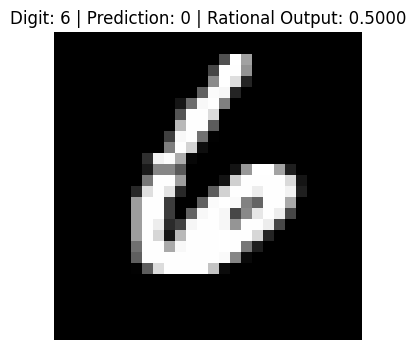

In [23]:
def visual_cross_check_rational_function(x_test_subset, x_test_binary, y_test_subset, models_dir):
    """
    Visual cross-check for rational function output.
    Displays the selected test image, the actual label, and the rational function's output.
    """
    import matplotlib.pyplot as plt

    # Step 1: Create subsets for each digit
    digit_subsets = {}
    digit_indices = {}
    for digit in range(10):
        indices = np.where(y_test_subset == digit)[0]
        digit_subsets[digit] = x_test_binary[indices]
        digit_indices[digit] = indices

    # Step 2: Select digit and index
    selected_digit = int(input("Enter the digit (0-9) to cross-check: "))
    if selected_digit not in digit_subsets:
        print(f"Invalid digit {selected_digit}.")
        return

    print(f"Number of images for digit {selected_digit}: {len(digit_subsets[selected_digit])}")
    selected_index = int(input(f"Enter the index (0-{len(digit_subsets[selected_digit]) - 1}) to select an image: "))
    if selected_index < 0 or selected_index >= len(digit_subsets[selected_digit]):
        print(f"Invalid index {selected_index}.")
        return

    selected_image_binary = digit_subsets[selected_digit][selected_index]
    original_image_index = digit_indices[selected_digit][selected_index]
    selected_image_original = x_test_subset[original_image_index]

    # Step 3: Load the corresponding model
    with open(f"{models_dir}classifier_{selected_digit}.pkl", "rb") as file:
        model = pickle.load(file)

    alpha = model["alpha"]
    beta = model["beta"]

    # Step 4: Evaluate the rational function
    rational_output = rational_function(selected_image_binary, alpha, beta)
    prediction = 1 if rational_output > 0.5 else 0

    # Step 5: Display the image, label, and rational function output
    plt.figure(figsize=(4, 4))
    plt.imshow(selected_image_original.reshape(28, 28), cmap="gray")  # Reshape to 28x28
    plt.title(f"Digit: {selected_digit} | Prediction: {prediction} | Rational Output: {rational_output:.4f}")
    plt.axis("off")
    plt.show()

# Main execution for visual cross-check
if __name__ == "__main__":
    # Visual cross-check
    visual_cross_check_rational_function(x_test_subset, x_test_binary, y_test_subset, models_dir)